0it [00:00, ?it/s]

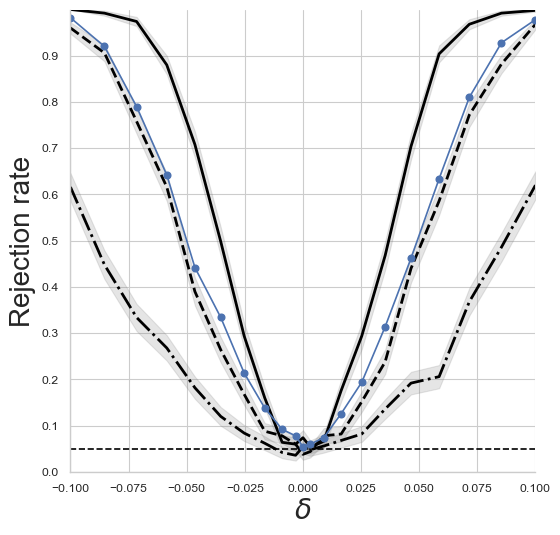

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import jax
import jax.numpy as jnp
from functools import partial
import plotting
from scipy.stats import chi2
from manifold import geodesic
from sphere import Sphere as S, proj_comp

import seaborn as sns


def mixture(key, x0, x1, p):
    num_dims = len(x0.shape) - 1
    shape = (x0.shape[0], *[1 for _ in range(num_dims)])
    z = jax.random.choice(
        key, jnp.array([0.0, 1.0]), shape=shape, p=jnp.array([p, 1 - p])
    )
    return z * x0 + (1.0 - z) * x1


@jax.jit
def kappa_star(R):
    return jnp.where(
        R < 0.53,
        2 * R + R**3 + 5 * R**5 / 6,
        jnp.where(
            R < 0.85, -0.4 + 1.39 * R + 0.43 / (1 - R), 1 / (R**3 - 4 * R**2 + 3 * R)
        ),
    )


@jax.jit
def mardia_jupp(angles, mu_0):
    n = angles.shape[0]

    c_bar = jnp.mean(jnp.cos(angles))
    s_bar = jnp.mean(jnp.sin(angles))
    R = jnp.sqrt(c_bar**2 + s_bar**2)

    s_bar_st = jnp.mean(jnp.sin(angles - mu_0))

    kappa = kappa_star(R)

    t = n * kappa / R * (s_bar_st**2)

    return t > chi2.ppf(1 - alpha, df=1)


@partial(jax.jit, static_argnums=(1,))
def sample_von_mises(key, n, mu):
    vs = 0.2 * jax.random.normal(key, (n, mu.shape[0]))
    return jax.vmap(lambda v: S.exp(mu, proj_comp(mu, v)))(vs)


def proc_inner(n, sampler, sampler_args, mu_0, key):
    x_key, key = jax.random.split(key, 2)
    x = sampler(x_key, n, *sampler_args)

    angles = jnp.atan2(x[:, 1], x[:, 0])
    mu_0_angle = jnp.arctan2(mu_0[1], mu_0[0])

    return mardia_jupp(angles, mu_0_angle)


def eval_test_mc(n, sampler, sampler_args, mu_0):
    key = jax.random.PRNGKey(np.random.randint(0, 2**32))
    subkeys = jax.random.split(key, mc_repeats)
    rejects = jax.vmap(lambda key: proc_inner(n, sampler, sampler_args, mu_0, key))(
        subkeys
    )
    return rejects.mean(), rejects.std()


sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "paper", rc={"axes.legendsize": 20, "axes.labelsize": 20, "axes.xtickssize": 20}
)

alpha = 0.05
num_bootstrap = 1000
mc_repeats = 500

n = 25

mu_0 = jnp.array([0.0, 1.0])
mu_1 = jnp.array([1.0, 0.0])
mu_delta = lambda delta: geodesic(S, mu_0, mu_1, delta)

delta_rates = np.zeros(21)
delta_rates_std = np.zeros(21)
_x = np.linspace(-1, 1, delta_rates.shape[0])
deltas = 0.1 * np.sign(_x) * (np.abs(_x) ** 1.5)

for i, delta in tqdm(enumerate(deltas)):
    rm, rs = eval_test_mc(n, sample_von_mises, (mu_delta(delta),), mu_0)
    delta_rates[i] = rm
    delta_rates_std[i] = rs


plotting.plot_sizes("sim_results/small_circle_vm", 1000, ns=[10, 25, 50])
plt.plot(deltas, delta_rates, marker="o")

0it [00:00, ?it/s]

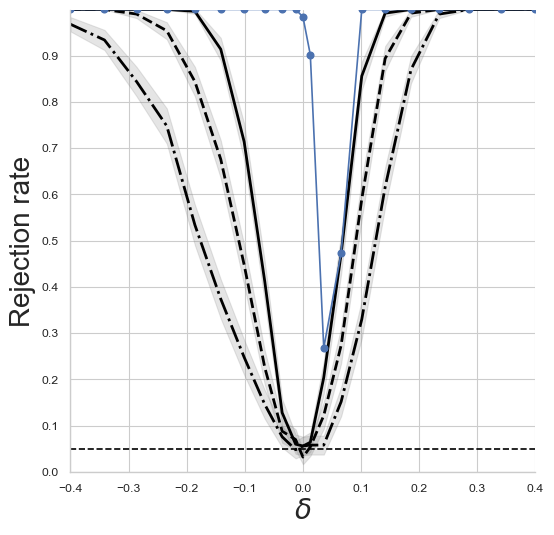

In [ ]:
@partial(jax.jit, static_argnums=(1,))
def sample_mixture(key, n, mu0, mu1, p):
    key_z, key_x0, key_x1 = jax.random.split(key, 3)
    x0 = sample_von_mises(key_x0, n, mu0)
    x1 = sample_von_mises(key_x1, n, mu1)
    return mixture(key_z, x0, x1, p)


# sampling from a mixture of two gaussians with mean angles 0 and pi/2 and mixture weight 1/3
# the sample mean is then the angle pi/6
mix_mu_0 = jnp.array([0.0, 1.0])
mix_mu_1 = jnp.array([1.0, 0.0])
p = 1 / 3
mu_0 = geodesic(S, mix_mu_0, mix_mu_1, p)
mu_1 = jnp.array([1.0, 0.0])

delta_rates = np.zeros(21)
delta_rates_std = np.zeros(delta_rates.shape[0])
_x = np.linspace(-1, 1, delta_rates.shape[0])
deltas = 0.4 * np.sign(_x) * (np.abs(_x) ** 1.5)

n = 4000

for i, delta in tqdm(enumerate(deltas)):
    sampler_args = (
        geodesic(S, mix_mu_0, mu_1, delta),
        geodesic(S, mix_mu_1, mu_1, delta),
        p,
    )
    rm, rs = eval_test_mc(n, sample_mixture, sampler_args, mu_0)

    delta_rates[i] = rm
    delta_rates_std[i] = rs

plotting.plot_sizes("sim_results/circle_mix", mc_repeats)
plt.plot(deltas, delta_rates, marker="o")